In [51]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [52]:
window = 5

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

df = df.sort_values(by='Date')

targ = 'LMCADY_acu_{}d_log'.format(window)
time_series = df[targ]

time_series

Date
2003-01-02    0.040542
2003-01-03    0.015400
2003-01-06    0.011601
2003-01-07    0.027062
2003-01-08    0.023340
                ...   
2024-04-08    0.023212
2024-04-09    0.007737
2024-04-10    0.026616
2024-04-11    0.046886
2024-04-12    0.048523
Name: LMCADY_acu_5d_log, Length: 5550, dtype: float64

In [53]:
if      window ==   5:
    test_size = 0.0050
elif    window ==   10:
    test_size = 0.0075
elif    window ==   20:
    test_size = 0.0100
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=test_size, shuffle=False)

In [54]:
# def find_best_sarima(time_series, max_p = 2, max_d = 2, max_q = 2):

#     p = range(0, max_p)
#     d = range(0, max_d)
#     q = range(0, max_q)
#     seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#     best_aic = float("inf")
#     best_param = None

#     for parametros in seasonal_pdq:
#         try:
#             modelo_sarima = SARIMAX(    time_series,
#                                         order=(1, 1, 1),  
#                                         seasonal_order=parametros,
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#             resultados = modelo_sarima.fit(disp=False)  
            
#             if resultados.aic < best_aic:
#                 best_aic = resultados.aic
#                 best_param = parametros
#         except Exception as e:
#             print('Error al ajustar SARIMA con:', parametros, 'Error:', e)
#             continue

#     return best_param, best_aic

In [55]:
# p = d = q = 3  # Puedes aumentar el rango según las necesidades del modelo

# best_param, best_aic = find_best_sarima(LMCADY_train, p, d, q)

In [56]:
# best_param, best_aic
# ((0, 0, 0, 12), -25917.98003298476)

best_param, best_aic = ((0, 0, 0, 12), -25917.98003298476)

In [57]:
def evaluate_sarima_model(train_series, test_series, P, D, Q, m, p=1, d=1, q=1):
    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []
    current_train = train_series.copy()

    for actual in test_series:
        model_sarima = SARIMAX(current_train, order=(p, d, q), seasonal_order=(P, D, Q, m),
                               enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model_sarima.fit(disp=False)  # disp=False para evitar impresión de información de ajuste

        prediction = model_fit.predict(start=len(current_train), end=(len(current_train)+window-1))
        print('Prediction array :\n', prediction)
        print('Prediction: {:.6f}, real {:.6f}'.format(prediction.iloc[-1], actual))

        predictions.append(prediction.iloc[0])
        current_train = pd.concat([current_train, pd.Series([actual], index=[current_train.index[-1] + pd.DateOffset(days=1)])])

    return pd.Series(predictions, index=test_series.index)


In [58]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [59]:
LMCADY_test_orig = LMCADY_test.copy()

LMCADY_test = LMCADY_test.shift(-window)
LMCADY_test.dropna(inplace=True)

LMCADY_predictions = evaluate_sarima_model(LMCADY_train, LMCADY_test_orig, 1, 1, 1, 12)

LMCADY_predictions = LMCADY_predictions[:-window]
LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)

/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

Prediction array :
 5522    0.016381
5523    0.011431
5524    0.009644
5525    0.007280
5526    0.005228
Name: predicted_mean, dtype: float64
Prediction: 0.005228, real 0.040335


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5523    0.031081
5524    0.026239
5525    0.021124
5526    0.016914
5527    0.016455
Name: predicted_mean, dtype: float64
Prediction: 0.016455, real 0.027326


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5524    0.022157
5525    0.017175
5526    0.012975
5527    0.010920
5528    0.008325
Name: predicted_mean, dtype: float64
Prediction: 0.008325, real 0.055151


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5525    0.042683
5526    0.032803
5527    0.026484
5528    0.020164
5529    0.014586
Name: predicted_mean, dtype: float64
Prediction: 0.014586, real 0.048621


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5526    0.037340
5527    0.029818
5528    0.022770
5529    0.016461
5530    0.013638
Name: predicted_mean, dtype: float64
Prediction: 0.013638, real 0.035584


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5527    0.027966
5528    0.021494
5529    0.015055
5530    0.012435
5531    0.009291
Name: predicted_mean, dtype: float64
Prediction: 0.009291, real -0.001656


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5528   -0.001702
5529   -0.002584
5530   -0.001197
5531   -0.001519
5532   -0.002197
Name: predicted_mean, dtype: float64
Prediction: -0.002197, real 0.006176


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5529    0.003527
5530    0.003544
5531    0.002161
5532    0.000659
5533    0.000003
Name: predicted_mean, dtype: float64
Prediction: 0.000003, real -0.023975


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5530   -0.021013
5531   -0.020406
5532   -0.021111
5533   -0.021330
5534   -0.018825
Name: predicted_mean, dtype: float64
Prediction: -0.018825, real -0.025755


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5531   -0.020548
5532   -0.016941
5533   -0.013637
5534   -0.007836
5535   -0.007273
Name: predicted_mean, dtype: float64
Prediction: -0.007273, real -0.013887


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5532   -0.011770
5533   -0.009594
5534   -0.004576
5535   -0.004800
5536   -0.001422
Name: predicted_mean, dtype: float64
Prediction: -0.001422, real -0.008478


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5533   -0.005622
5534   -0.001716
5535   -0.003772
5536    0.000729
5537    0.000836
Name: predicted_mean, dtype: float64
Prediction: 0.000836, real -0.008083


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5534   -0.003527
5535   -0.003929
5536   -0.000937
5537   -0.000667
5538   -0.001065
Name: predicted_mean, dtype: float64
Prediction: -0.001065, real 0.001195


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5535   -0.000469
5536    0.000635
5537    0.000357
5538   -0.000233
5539    0.000123
Name: predicted_mean, dtype: float64
Prediction: 0.000123, real 0.001013


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5536    0.002844
5537    0.002287
5538    0.001205
5539    0.000352
5540    0.000369
Name: predicted_mean, dtype: float64
Prediction: 0.000369, real 0.015830


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5537    0.012340
5538    0.009029
5539    0.006371
5540    0.004953
5541    0.001282
Name: predicted_mean, dtype: float64
Prediction: 0.001282, real 0.045403


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5538    0.042783
5539    0.042274
5540    0.041719
5541    0.039875
5542    0.040924
Name: predicted_mean, dtype: float64
Prediction: 0.040924, real 0.052826


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5539    0.040374
5540    0.031381
5541    0.021816
5542    0.017406
5543    0.013327
Name: predicted_mean, dtype: float64
Prediction: 0.013327, real 0.049188


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5540    0.038202
5541    0.027095
5542    0.021485
5543    0.016473
5544    0.011717
Name: predicted_mean, dtype: float64
Prediction: 0.011717, real 0.057085


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5541    0.054196
5542    0.054816
5543    0.054397
5544    0.053305
5545    0.052920
Name: predicted_mean, dtype: float64
Prediction: 0.052920, real 0.043476


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5542    0.044917
5543    0.044878
5544    0.043923
5545    0.043593
5546    0.046126
Name: predicted_mean, dtype: float64
Prediction: 0.046126, real 0.009776


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5543    0.008363
5544    0.005693
5545    0.004044
5546    0.004418
5547    0.001639
Name: predicted_mean, dtype: float64
Prediction: 0.001639, real -0.003486


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5544   -0.003747
5545   -0.003681
5546   -0.000596
5547   -0.001477
5548    0.000482
Name: predicted_mean, dtype: float64
Prediction: 0.000482, real 0.013451


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5545    0.009877
5546    0.009958
5547    0.006798
5548    0.007166
5549    0.007060
Name: predicted_mean, dtype: float64
Prediction: 0.007060, real 0.023212


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecastin

Prediction array :
 5546    0.020289
5547    0.014749
5548    0.013094
5549    0.011199
5550    0.008860
Name: predicted_mean, dtype: float64
Prediction: 0.008860, real 0.007737


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5547    0.005020
5548    0.005592
5549    0.005480
5550    0.004481
5551    0.004093
Name: predicted_mean, dtype: float64
Prediction: 0.004093, real 0.026616


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

Prediction array :
 5548    0.022227
5549    0.018188
5550    0.014220
5551    0.011581
5552    0.009416
Name: predicted_mean, dtype: float64
Prediction: 0.009416, real 0.046886


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction array :
 5549    0.039650
5550    0.032550
5551    0.028141
5552    0.025195
5553    0.019246
Name: predicted_mean, dtype: float64
Prediction: 0.019246, real 0.048523


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
def plot_predictions(test_series, predictions, title, best_lags = "", markersize=3):
    plt.figure(figsize=(14, 3))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)


    plt.title(f"SARIMA Model: {title}")
    plt.legend()
    plt.show()

In [61]:
LMCADY_rmse

0.04053894111639229

In [62]:
LMCADY_test.describe()['std']

0.02584884949745301

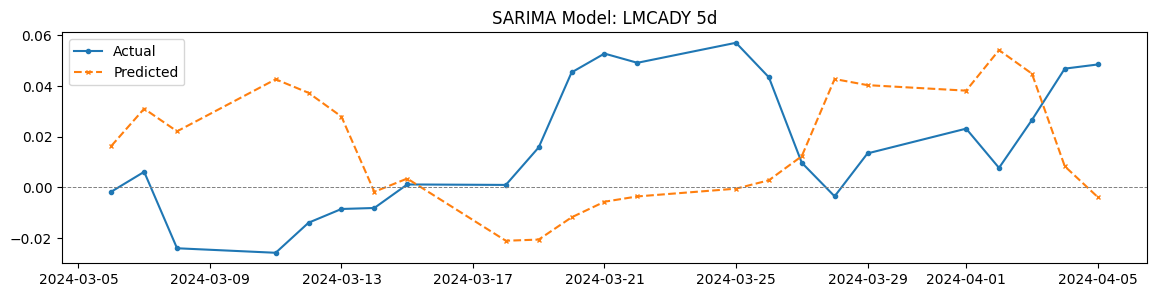

In [63]:
plot_predictions(LMCADY_test, LMCADY_predictions, "LMCADY {}d".format(window))